In [ ]:
from typing import TypedDict

from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

In [ ]:
llm = ChatOpenAI(model="mistralai/devstral-small")

In [ ]:
class ReasoningState(TypedDict):
    question: str
    initial_answer: str
    reasoning_steps: list[str]
    reflection: str
    final_answer: str
    confidence: float
    needs_revision: bool

In [ ]:
class Reason(BaseModel):
    answer: str = Field(description="The primary answer to the question")
    reasoning: list[str] = Field(description="Step-by-step reasoning process")
    confidence: float = Field(
        description="Confidence level (0.0 to 1.0)", ge=0.0, le=1.0
    )


class MetaReasoning(BaseModel):
    reflection: str = Field(description="Critical analysis of the reasoning process")
    needs_revision: bool = Field(description="Whether the answer needs to be revised")

In [ ]:
def initial_reasoning(state: ReasoningState):
    prompt = ChatPromptTemplate.from_template(
        """
    Question: {question}
    
    Please provide:
    1. Your initial answer
    2. Step-by-step reasoning that led to this answer
    3. Rate your confidence (0-1)
    """
    )

    structured_llm = llm.with_structured_output(Reason)
    response = structured_llm.invoke(prompt.format(question=state["question"]))

    return {
        **state,
        "initial_answer": response.answer,
        "reasoning_steps": response.reasoning,
        "confidence": response.confidence,
    }

In [ ]:
def meta_reflection(state: ReasoningState):
    prompt = f"""
    Question: {state['question']}
    Initial Answer: {state['initial_answer']}
    Reasoning Steps: {', '.join(state['reasoning_steps'])}
    Confidence: {state['confidence']}
    
    As a meta-reasoning critic, analyze this reasoning process:
    
    1. Are there any logical flaws or gaps in the reasoning?
    2. Are there alternative approaches that might be better?
    3. Are there any assumptions that should be questioned?
    4. Is the confidence level appropriate?
    5. Should this answer be revised?
    """

    structured_llm = llm.with_structured_output(MetaReasoning)
    response = structured_llm.invoke(prompt)

    return {
        **state,
        "reflection": response.reflection,
        "needs_revision": response.needs_revision,
    }

In [ ]:
class Revised(BaseModel):
    final_answer: list[str] = Field(
        description="The revised answer based on the question"
    )
    confidence: float = Field(
        description="Confidence level (0.0 - 1.0)", ge=0.0, le=1.0
    )

In [ ]:
def revised_reasoning(state: ReasoningState):
    prompt = ChatPromptTemplate.from_template(
        """
    Original Question: {question}
    Initial Answer: {initial_answer}
    Initial Reasoning: {reasoning}
    Meta-Reflection: {reflection}

    Based on the reflection, provide a revised answer that addresses the identified issues.
    """
    )

    structured_llm = llm.with_structured_output(Revised)
    response = structured_llm.invoke(
        prompt.format_messages(
            question=state["question"],
            initial_answer=state["initial_answer"],
            reasoning=", ".join(state["reasoning_steps"]),
            reflection=state["reflection"],
        )
    )

    return {
        **state,
        "final_answer": response.final_answer,
        "confidence": response.confidence,
    }

In [ ]:
def finalize_answer(state: ReasoningState) -> ReasoningState:
    """Use initial answer as final if no revision needed"""
    return {**state, "final_answer": state["initial_answer"]}

In [ ]:
def should_revise(state: ReasoningState) -> str:
    """Determine if revision is needed based on reflection"""
    if state["needs_revision"]:
        return "revise"
    else:
        return "finalize"

In [ ]:
def create_meta_reasoning_graph():
    workflow = StateGraph(ReasoningState)

    # Add nodes
    workflow.add_node("initial_reasoning", initial_reasoning)
    workflow.add_node("meta_reflection", meta_reflection)
    workflow.add_node("revised_reasoning", revised_reasoning)
    workflow.add_node("finalize_answer", finalize_answer)

    # Add edges
    workflow.set_entry_point("initial_reasoning")
    workflow.add_edge("initial_reasoning", "meta_reflection")
    workflow.add_conditional_edges(
        "meta_reflection",
        should_revise,
        {"revise": "revised_reasoning", "finalize": "finalize_answer"},
    )
    workflow.add_edge("revised_reasoning", END)
    workflow.add_edge("finalize_answer", END)

    return workflow.compile()

In [ ]:
graph = create_meta_reasoning_graph()

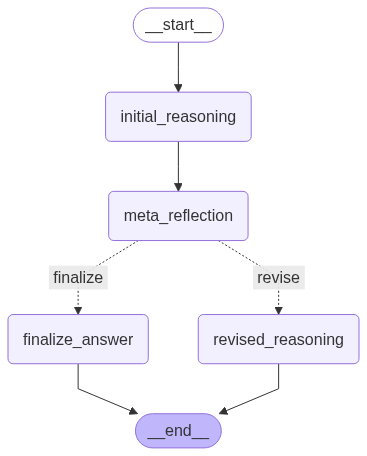

In [ ]:
graph

In [ ]:
def run_meta_reasoning_example():
    graph = create_meta_reasoning_graph()

    # Test question
    initial_state = ReasoningState(
        question="A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?",
        initial_answer="",
        reasoning_steps=[],
        reflection="",
        final_answer="",
        confidence=0.0,
        needs_revision=False,
    )

    # Run the graph
    result = graph.invoke(initial_state)

    print("=== Meta Reasoning Results ===")
    print(f"Question: {result['question']}")
    print(f"Initial Answer: {result['initial_answer']}")
    print(f"Reasoning Steps: {result['reasoning_steps']}")
    print(f"Reflection: {result['reflection']}")
    print(f"Needs Revision: {result['needs_revision']}")
    print(f"Final Answer: {result['final_answer']}")
    print(f"Final Confidence: {result['confidence']}")

    return result

In [ ]:
result = run_meta_reasoning_example()

=== Meta Reasoning Results ===
Question: A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?
Initial Answer: The ball costs 0.05 cents.
Reasoning Steps: ['We know that the bat costs $1.00 more than the ball. So, bat = ball + $1.00.', 'Also, bat + ball = $1.10.', 'If we substitute bat from the first equation to the second, we get: (ball + $1.00) + ball = $1.10.', 'This simplifies to: 2*ball = $0.10.', 'Dividing both sides by 2, we get: ball = $0.05.']
Reflection: There's a fundamental flaw in the reasoning steps provided. The initial answer states that "The ball costs 0.05 cents", but the problem states that the bat and the ball cost $1.10 in total. The ball costs 0.05 dollars (or 5 cents), not 0.05 cents. This mistake can lead to confusion and misinterpretation.

Let's analyze the problem step by step:
1. We know that bat + ball = $1.10.
2. We also know that bat = ball + $1.00.
3. Replacing bat in the first equation, we get (ball +